# Data Preparation Pipeline

Prepare data in order to do training and prediction. 

The output of this is a set of descriptors with corresponding lables. 

In [2]:
## IMPORTS
import os
import matplotlib.pyplot as plt
import numpy as np 
import cv2 as cv
from scipy.cluster.vq import kmeans, vq

from sklearn.svm import SVC
from sklearn.utils import shuffle

In [3]:
##PATHS 
EXAMPLE_IMAGE = "./data/raw/img/closedHand/IMG_4543.JPG"

PATH_OPEN = "./data/raw/img/openHand/"
PATH_CLOSED = "./data/raw/img/closedHand/"

PATH_CLOSED_TEST1 = "./data/raw/img/closed1.png"
PATH_CLOSED_TEST2 = "./data/raw/img/closed2.png"
PATH_CLOSED_TEST3 = "./data/raw/img/closed3.png"
PATH_OPEN_TEST1 = "./data/raw/img/open1.png"
PATH_OPEN_TEST2 = "./data/raw/img/open2.png"
PATH_OPEN_TEST3 = "./data/raw/img/open3.png"


In [4]:

def gaussian(I, sigma):
    """
    Applies a 2-D Gaussian blur with standard deviation sigma to
    a grayscale image I.
    """
    h = int(np.ceil(3*sigma))
    x = np.linspace(-h, +h, 2*h + 1)
    g = np.exp(-x**2/(2*sigma**2))/np.sqrt(2*np.pi*sigma**2)
    Ig = np.zeros_like(I)
    for row in range(I.shape[0]): Ig[row,:] = np.convolve(I[row,:], g, mode='same')
    for col in range(I.shape[1]): Ig[:,col] = np.convolve(Ig[:,col], g, mode='same')
    return Ig

def compute_skin_mask(I): 
    imgYCC = cv.cvtColor(I, cv.COLOR_BGR2YCR_CB)

    Y = imgYCC[:, :, 0]
    CR = imgYCC[:, :, 1]
    CB = imgYCC[:, :, 2]

    Y_mask = (Y>80)
    CB_mask = (85<CB)&(CB<135)
    CR_mask = (135<CR)&(CR<180)

    return Y_mask&CR_mask&CB_mask

def prediction_enterp(pred):

    if pred == 0: 
        print("Prediction: OPEN HAND") 
    
    elif pred == 1: 
        print("Prediction: CLOSED HAND")

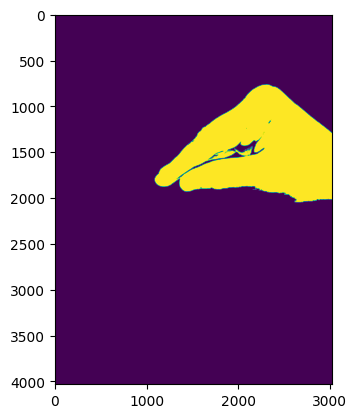

In [5]:

I = cv.imread(EXAMPLE_IMAGE)

result = compute_skin_mask(I)

plt.imshow(result)


In [111]:


nfeatures = 100

orb = cv.ORB_create(nfeatures=nfeatures)

open_descriptors = []
open_keypoints = []

num_images = 0

thresh = 127

lower = np.array([160])
upper = np.array([255])

## RETRIEVING OPEN HAND DESCRIPTORS 

for image in os.listdir(PATH_OPEN): 

    num_images += 1 
    
    I = cv.imread(PATH_OPEN + image)
    I = (compute_skin_mask(I)*255).astype(np.uint8)

    kp = orb.detect(I)
    kp, des = orb.compute(I, kp)

    if (des.shape[0] > nfeatures) : 

        n = np.abs(des.shape[0] - nfeatures)
        des = np.delete(des, np.arange(nfeatures, nfeatures+n, 1), 0)
        kp = np.delete(kp, np.arange(nfeatures, nfeatures+n, 1), 0)

    open_descriptors.append(des)
    open_keypoints.append(kp)

## RETRIEVING CLOSED HAND DESCRIPTORS
    
thresh = 127

for image in os.listdir(PATH_CLOSED): 

    num_images += 1 
    
    I = cv.imread(PATH_CLOSED + image)
    I = (compute_skin_mask(I)*255).astype(np.uint8)

    kp = orb.detect(I)
    kp, des = orb.compute(I, kp)

    if (des.shape[0] > nfeatures) : 

        n = np.abs(des.shape[0] - nfeatures)
        des = np.delete(des, np.arange(nfeatures, nfeatures+n, 1), 0)
        kp = np.delete(kp, np.arange(nfeatures, nfeatures+n, 1), 0)

    open_descriptors.append(des)
    open_keypoints.append(kp)

all_descriptors = []

for descriptors in open_descriptors: 
    for descriptor in descriptors: 
        all_descriptors.append(descriptor)


all_descriptors = np.stack(all_descriptors, dtype=float)
    

: 

# K-Means Pipeline

Utilize k-means in order to create e image-vocabulary for later trainign to recognize hand gesture.

In [87]:

n_clusters = 300
iters = 1
codebook, variance = kmeans(all_descriptors, n_clusters, iters, seed=42) 


In [88]:
visualWords = [] 

for img_descriptors in open_descriptors: 
    img_descriptors = img_descriptors.astype(float)
    img_visual_words, distance = vq(img_descriptors, codebook)
    visualWords.append(img_visual_words)



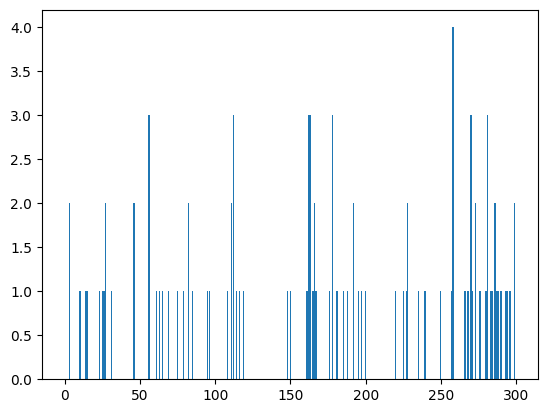

In [89]:
frequency_vectors = []

for img_visual_words in visualWords: 
    img_freq_vec = np.zeros(n_clusters)

    for word in img_visual_words: 
        img_freq_vec[word] += 1
    
    frequency_vectors.append(img_freq_vec)


frequency_vectors = np.stack(frequency_vectors)

plt.bar(list(range(n_clusters)), frequency_vectors[201])
plt.show()


# SVM Pipeline 

This part uses Support Vector Machine to train on the dictionary. 


In [90]:

y = np.ones((frequency_vectors.shape[0], ))
y[:189] = 0

X, y= shuffle(frequency_vectors, y, random_state=42)

svc = SVC(random_state=42, kernel="rbf")
svc.fit(X, y)


SVC(random_state=42)

# Testing on new images

Pipeline for new images 

1. Use ORB to extract features
2. feed these descriptors into the trained kmeans to cluster this gives us the visual words in that new image 
3. we create the frequency vector from the visual words, counting how many instanses of each word in our dictionary we encounter. 
4. use the SVM to predict which gesture

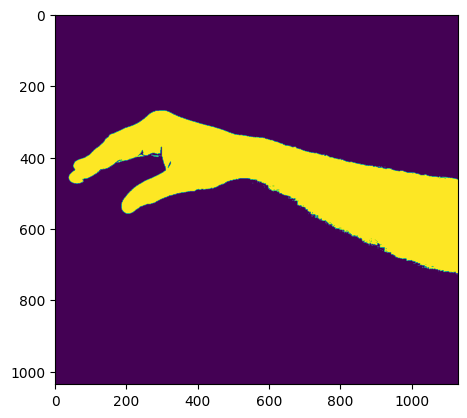

(<matplotlib.image.AxesImage at 0x2a33f7790>, None)

In [97]:
# loading image, imagine this coming from webcam 

I_test = cv.imread(PATH_OPEN_TEST2)
I_test = (compute_skin_mask(I_test)*255).astype(np.uint8)


plt.imshow(I_test), plt.show()


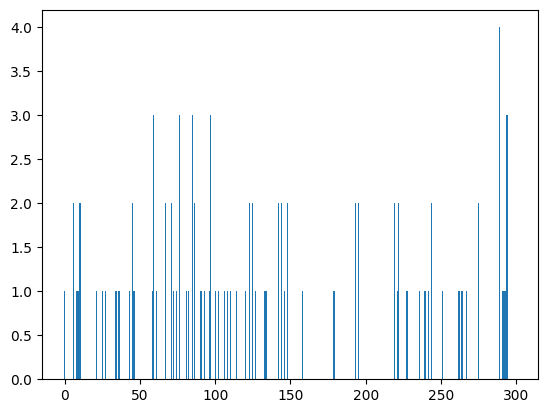

In [98]:
kp = orb.detect(I_test)
kp, des = orb.compute(I_test, kp)
test_visual_words, distance = vq(des, codebook)

img_freq_vec = np.zeros(n_clusters)

for word in test_visual_words: 
    img_freq_vec[word] += 1

plt.bar(list(range(n_clusters)), img_freq_vec)
plt.show()



In [99]:
pred = svc.predict(img_freq_vec.reshape(1, -1))
prediction_enterp(pred[0])

Prediction: OPEN HAND


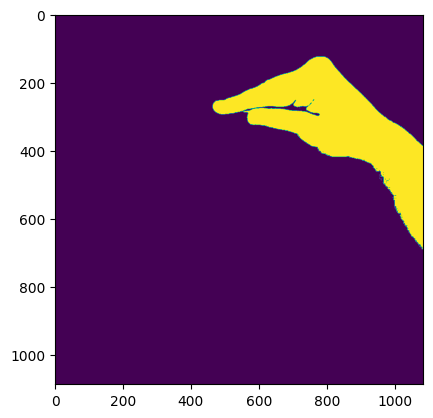

(<matplotlib.image.AxesImage at 0x16e25f7c0>, None)

In [106]:
# loading image, imagine this coming from webcam

I_test = cv.imread(PATH_CLOSED_TEST3)
I_test = (compute_skin_mask(I_test)*255).astype(np.uint8)
plt.imshow(I_test), plt.show()

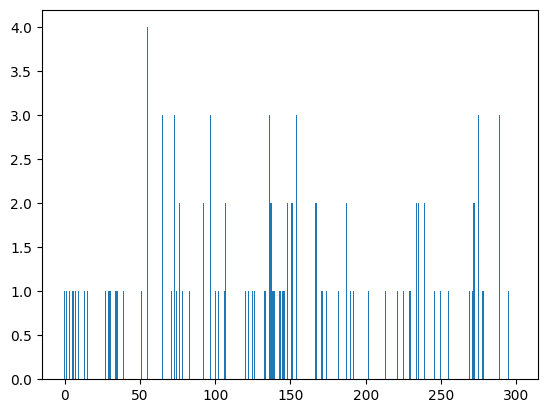

(300,)

In [107]:
kp = orb.detect(I_test)
kp, des = orb.compute(I_test, kp)
test_visual_words, distance = vq(des, codebook)
img_freq_vec = np.zeros(n_clusters)

for word in test_visual_words: 
    img_freq_vec[word] += 1

plt.bar(list(range(n_clusters)), img_freq_vec)
plt.show()
img_freq_vec.shape

In [108]:
pred = svc.predict(img_freq_vec.reshape(1, -1))

prediction_enterp(pred[0])


Prediction: CLOSED HAND


# Testing in video 

In [110]:

frameWidth = 450
frameHeight = 640
cap = cv.VideoCapture(1)
cap.set(3, frameWidth)
cap.set(4, frameHeight)
cap.set(10,150)

counters = []
lower = np.array([160])
upper = np.array([255])

while True:

    success, img = cap.read()
    I = (compute_skin_mask(img)*255).astype(np.uint8)

    kp = orb.detect(I)
    kp, des = orb.compute(I, kp)

    if ( kp or des): 

        test_visual_words, distance = vq(des, codebook)

        img_freq_vec = np.zeros(n_clusters)

        for word in test_visual_words: 
            img_freq_vec[word] += 1

        pred = svc.predict(img_freq_vec.reshape(1, -1))

        counters.append(pred)
        if len(counters) > 10: 
            counters.pop(0)

        avg_pred = sum(counters)/len(counters)

        print(prediction_enterp(round(avg_pred[0])))
    

    cv.imshow("Result", I)
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CLOSED HAND
None
Prediction: CL